In [1]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist

In [3]:
batch_size = 128
num_classes = 10
epochs = 15
# input image dimensions
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

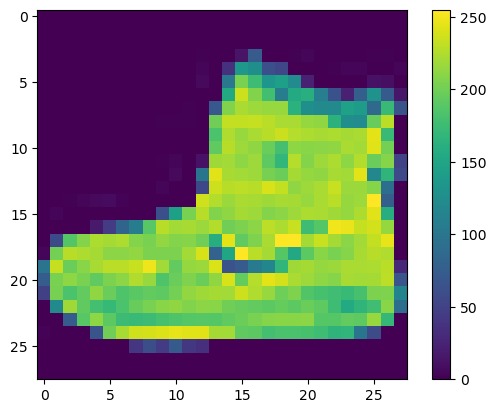

In [4]:
plt.figure()
plt.imshow(X_train_full[0])
plt.colorbar()

In [5]:
X_train_full = X_train_full.astype("float32") / 255
X_test = X_test.astype("float32") / 255
X_train_full = np.expand_dims(X_train_full, -1)
X_test = np.expand_dims(X_test, -1)

In [6]:
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [7]:
# y_train = keras.utils.to_categorical(y_train, num_classes)  # type: ignore
# y_valid = keras.utils.to_categorical(y_valid, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [11]:
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=3)
    n_neurons = hp.Int("n_neurons", min_value=32, max_value=128, step=32)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
    kernel_list = hp.Choice("kernel_initializer", values=["random_normal", "random_uniform", "zeros", "ones", "glorot_normal", "glorot_uniform"])
    optimizer = hp.Choice("optimizer", values=["sgd", "adam", "adadelta", "rmsprop", "adamax", "adagrad"])
    activation_list = hp.Choice("activation", values=['relu', 'softmax', 'tanh', 'sigmoid'])
    drop_out = hp.Float("drop_out", min_value=.2, max_value=1)
    # pool_size = hp.Int("pool_size", min_value=2, max_value=2)
    # kernel_size = hp.Int("kernel_size", min_value=2, max_value=3)
    input_shape = (28, 28, 1)
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == "adadelta":
        optimizer = tf.keras.optimizers.Adadelta(learning_rate=learning_rate)
    elif optimizer == "rmsprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "adamax":
        optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
        
    model = tf.keras.Sequential()
    # model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Conv2D(n_neurons, kernel_size=(3,3), activation=activation_list, kernel_initializer=kernel_list, input_shape=(28, 28, 1)))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(tf.keras.layers.Dropout(drop_out))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

In [12]:
random_search_tuner = kt.RandomSearch(
    build_model, 
    objective="val_accuracy", 
    max_trials=10,
    executions_per_trial=5,
    overwrite=True,
    directory="my_fashion_mnist", 
    project_name="HP_Fashion_MNIST", 
    seed=42)

random_search_tuner.search(X_train, y_train, epochs=10,
                           validation_data=(X_valid, y_valid))

Trial 10 Complete [00h 36m 48s]
val_accuracy: 0.10012000054121017

Best val_accuracy So Far: 0.8782400131225586
Total elapsed time: 03h 48m 59s
INFO:tensorflow:Oracle triggered exit


In [13]:
top3_models = random_search_tuner.get_best_models(num_models=5)
best_model = top3_models[0]

In [14]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=5)
for i in range(len(top3_params)):
    print(f'Top Param {i} : \n {top3_params[i].values}\n')  # best hyperparameter values

Top Param 0 : 
 {'n_hidden': 2, 'n_neurons': 64, 'learning_rate': 0.0038287047044982298, 'kernel_initializer': 'random_uniform', 'optimizer': 'rmsprop', 'activation': 'relu', 'drop_out': 0.36293635793684126}

Top Param 1 : 
 {'n_hidden': 0, 'n_neurons': 64, 'learning_rate': 0.006678619769811224, 'kernel_initializer': 'glorot_normal', 'optimizer': 'adamax', 'activation': 'tanh', 'drop_out': 0.35562979834654485}

Top Param 2 : 
 {'n_hidden': 0, 'n_neurons': 64, 'learning_rate': 0.0003069273045576997, 'kernel_initializer': 'zeros', 'optimizer': 'adamax', 'activation': 'softmax', 'drop_out': 0.27227188341547964}

Top Param 3 : 
 {'n_hidden': 1, 'n_neurons': 64, 'learning_rate': 0.000195586335667274, 'kernel_initializer': 'glorot_normal', 'optimizer': 'adam', 'activation': 'sigmoid', 'drop_out': 0.9679687441559643}

Top Param 4 : 
 {'n_hidden': 1, 'n_neurons': 64, 'learning_rate': 0.0006752863927347823, 'kernel_initializer': 'random_normal', 'optimizer': 'sgd', 'activation': 'sigmoid', 'dro

In [15]:
best_trial= random_search_tuner.oracle.get_best_trials(num_trials=5)
for i in range(len(best_trial)):
    print(f'Best Train {i}')
    best_trial[i].summary()
    print(f'--------------')

Best Train 0
Trial summary
Hyperparameters:
n_hidden: 2
n_neurons: 64
learning_rate: 0.0038287047044982298
kernel_initializer: random_uniform
optimizer: rmsprop
activation: relu
drop_out: 0.36293635793684126
Score: 0.8782400131225586
--------------
Best Train 1
Trial summary
Hyperparameters:
n_hidden: 0
n_neurons: 64
learning_rate: 0.006678619769811224
kernel_initializer: glorot_normal
optimizer: adamax
activation: tanh
drop_out: 0.35562979834654485
Score: 0.8592000126838684
--------------
Best Train 2
Trial summary
Hyperparameters:
n_hidden: 0
n_neurons: 64
learning_rate: 0.0003069273045576997
kernel_initializer: zeros
optimizer: adamax
activation: softmax
drop_out: 0.27227188341547964
Score: 0.839799988269806
--------------
Best Train 3
Trial summary
Hyperparameters:
n_hidden: 1
n_neurons: 64
learning_rate: 0.000195586335667274
kernel_initializer: glorot_normal
optimizer: adam
activation: sigmoid
drop_out: 0.9679687441559643
Score: 0.8072399973869324
--------------
Best Train 4
Trial

In [16]:
best_trial[0].metrics.get_last_value("val_accuracy")

0.8782400131225586

In [17]:
best_model.fit(X_train_full, y_train_full, epochs=10)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

Epoch 1/10
1875/1875 [==============================] - 35s 19ms/step - loss: 0.4054 - accuracy: 0.8567
Epoch 2/10
1875/1875 [==============================] - 35s 19ms/step - loss: 0.4043 - accuracy: 0.8579
Epoch 3/10
1875/1875 [==============================] - 35s 19ms/step - loss: 0.4048 - accuracy: 0.8573
Epoch 4/10
1875/1875 [==============================] - 35s 19ms/step - loss: 0.4150 - accuracy: 0.8518
Epoch 5/10
1875/1875 [==============================] - 35s 19ms/step - loss: 0.4118 - accuracy: 0.8531
Epoch 6/10
1875/1875 [==============================] - 35s 19ms/step - loss: 0.4150 - accuracy: 0.8524
Epoch 7/10
1875/1875 [==============================] - 35s 19ms/step - loss: 0.4216 - accuracy: 0.8504
Epoch 8/10
1875/1875 [==============================] - 35s 19ms/step - loss: 0.4263 - accuracy: 0.8489
Epoch 9/10
1875/1875 [==============================] - 35s 19ms/step - loss: 0.4239 - accuracy: 0.8494
Epoch 10/10
313/313 [==============================] - 2s 5ms/st

**CIFAR10 fitting on top 3 model of Hyperparameter Tuning of Fashion MNIST CNN**

In [2]:
cifar_10 = tf.keras.datasets.cifar10.load_data()
(x_train, y_train), (x_test, y_test) = cifar_10

In [3]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples') 

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [20]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)  # type: ignore
y_test = keras.utils.to_categorical(y_test, num_classes)  # type: ignore

In [5]:
# Best model 1
n_hidden = 2
n_neurons = 64
learning_rate = 0.0038287047044982298
kernel_initializer = 'random_uniform'
optimizer = 'rmsprop'
activation = 'relu'
drop_out = 0.36293635793684126
# Score = 0.8782400131225586
best_model_1 = tf.keras.Sequential()
# best_model_1.add(tf.keras.layers.Flatten())
for _ in range(n_hidden):
    best_model_1.add(tf.keras.layers.Conv2D(n_neurons, kernel_size=(3,3), activation=activation, kernel_initializer=kernel_initializer, input_shape=(32, 32, 3)))
    best_model_1.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    best_model_1.add(tf.keras.layers.Dropout(drop_out))
best_model_1.add(tf.keras.layers.Flatten())
best_model_1.add(tf.keras.layers.Dense(10, activation="softmax"))
best_model_1.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

best_model_1.fit(x_train, y_train, epochs=12, validation_split=0.2)
test_loss, test_accuracy = best_model_1.evaluate(x_test, y_test)
print(f'Test Loss : {test_loss} \n Test Accuracy : {test_accuracy:.3%}')

Epoch 1/12
1250/1250 [==============================] - 47s 37ms/step - loss: 1.6914 - accuracy: 0.3904 - val_loss: 1.4277 - val_accuracy: 0.4983
Epoch 2/12
1250/1250 [==============================] - 50s 40ms/step - loss: 1.3667 - accuracy: 0.5178 - val_loss: 1.2605 - val_accuracy: 0.5696
Epoch 3/12
1250/1250 [==============================] - 50s 40ms/step - loss: 1.2411 - accuracy: 0.5656 - val_loss: 1.1460 - val_accuracy: 0.6128
Epoch 4/12
1250/1250 [==============================] - 51s 41ms/step - loss: 1.1637 - accuracy: 0.5951 - val_loss: 1.0721 - val_accuracy: 0.6352
Epoch 5/12
1250/1250 [==============================] - 50s 40ms/step - loss: 1.1087 - accuracy: 0.6183 - val_loss: 1.0504 - val_accuracy: 0.6403
Epoch 6/12
1250/1250 [==============================] - 52s 42ms/step - loss: 1.0777 - accuracy: 0.6293 - val_loss: 1.0113 - val_accuracy: 0.6577
Epoch 7/12
1250/1250 [==============================] - 52s 42ms/step - loss: 1.0502 - accuracy: 0.6387 - val_loss: 0.9650 -

In [10]:
# Best Model 2
n_hidden = 1
n_neurons = 64
learning_rate = 0.006678619769811224
kernel_initializer = 'glorot_normal'
optimizer = 'adamax'
activation = 'tanh'
drop_out = 0.35562979834654485
# Score = 0.8592000126838684
best_model_2 = tf.keras.Sequential()
# best_model_2.add(tf.keras.layers.Flatten())
for _ in range(n_hidden):
    best_model_2.add(tf.keras.layers.Conv2D(n_neurons, kernel_size=(3,3), activation=activation, kernel_initializer=kernel_initializer, input_shape=(32, 32, 3)))
    best_model_2.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    best_model_2.add(tf.keras.layers.Dropout(drop_out))
best_model_2.add(tf.keras.layers.Flatten())
best_model_2.add(tf.keras.layers.Dense(10, activation="softmax"))
best_model_2.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

best_model_2.fit(x_train, y_train, epochs=12, validation_split=0.2)
test_loss, test_accuracy = best_model_2.evaluate(x_test, y_test)
print(f'Test Loss : {test_loss} \n Test Accuracy : {test_accuracy:.3%}')

Epoch 1/12
1250/1250 [==============================] - 19s 15ms/step - loss: 1.6912 - accuracy: 0.4158 - val_loss: 1.5457 - val_accuracy: 0.4756
Epoch 2/12
1250/1250 [==============================] - 18s 14ms/step - loss: 1.4689 - accuracy: 0.4944 - val_loss: 1.4610 - val_accuracy: 0.5036
Epoch 3/12
1250/1250 [==============================] - 18s 14ms/step - loss: 1.3800 - accuracy: 0.5271 - val_loss: 1.3900 - val_accuracy: 0.5230
Epoch 4/12
1250/1250 [==============================] - 20s 16ms/step - loss: 1.3215 - accuracy: 0.5455 - val_loss: 1.3583 - val_accuracy: 0.5347
Epoch 5/12
1250/1250 [==============================] - 37s 30ms/step - loss: 1.2802 - accuracy: 0.5585 - val_loss: 1.3246 - val_accuracy: 0.5443
Epoch 6/12
1250/1250 [==============================] - 37s 30ms/step - loss: 1.2465 - accuracy: 0.5736 - val_loss: 1.3004 - val_accuracy: 0.5539
Epoch 7/12
1250/1250 [==============================] - 37s 30ms/step - loss: 1.2145 - accuracy: 0.5828 - val_loss: 1.2638 -

In [9]:
# Best Model 3
n_hidden = 1
n_neurons = 64
learning_rate = 0.0003069273045576997
kernel_initializer = 'zeros'
optimizer = 'adamax'
activation = 'softmax'
drop_out = 0.27227188341547964
# Score = 0.839799988269806
best_model_3 = tf.keras.Sequential()
# best_model_3.add(tf.keras.layers.Flatten())
for _ in range(n_hidden):
    best_model_3.add(tf.keras.layers.Conv2D(n_neurons, kernel_size=(3,3), activation=activation, kernel_initializer=kernel_initializer, input_shape=(32, 32, 3)))
    best_model_3.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    best_model_3.add(tf.keras.layers.Dropout(drop_out))
best_model_3.add(tf.keras.layers.Flatten())
best_model_3.add(tf.keras.layers.Dense(10, activation="softmax"))
best_model_3.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

best_model_3.fit(x_train, y_train, epochs=12, validation_split=0.2)
test_loss, test_accuracy = best_model_3.evaluate(x_test, y_test)
print(f'Test Loss : {test_loss} \n Test Accuracy : {test_accuracy:.3%}')

Epoch 1/12
1250/1250 [==============================] - 30s 23ms/step - loss: 2.1436 - accuracy: 0.2228 - val_loss: 2.0054 - val_accuracy: 0.2871
Epoch 2/12
1250/1250 [==============================] - 29s 23ms/step - loss: 1.9278 - accuracy: 0.3268 - val_loss: 1.8750 - val_accuracy: 0.3414
Epoch 3/12
1250/1250 [==============================] - 29s 23ms/step - loss: 1.8365 - accuracy: 0.3617 - val_loss: 1.8119 - val_accuracy: 0.3682
Epoch 4/12
1250/1250 [==============================] - 31s 25ms/step - loss: 1.7851 - accuracy: 0.3792 - val_loss: 1.7718 - val_accuracy: 0.3840
Epoch 5/12
1250/1250 [==============================] - 32s 25ms/step - loss: 1.7442 - accuracy: 0.3944 - val_loss: 1.7362 - val_accuracy: 0.3947
Epoch 6/12
1250/1250 [==============================] - 32s 25ms/step - loss: 1.7088 - accuracy: 0.4068 - val_loss: 1.6976 - val_accuracy: 0.4140
Epoch 7/12
1250/1250 [==============================] - 32s 25ms/step - loss: 1.6723 - accuracy: 0.4200 - val_loss: 1.6703 -